# Modeling and Simulation in Python

Case study: Hopper optimization

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
kg = UNITS.kilogram
m = UNITS.meter
s = UNITS.second
N = UNITS.newton

In [371]:
condition = Condition(mass = 0.03 * kg,
                      fraction = 1 / 3,
                      k = 9810.0 * N / m,
                      duration = 0.3 * s,
                      L = 0.05 * m,
                      d = 0.005 * m,
                      v1 = 0 * m / s,
                      v2 = 0 * m / s,
                      g = 9.8 * m / s**2)

In [384]:
condition = Condition(mass = 0.03,
                      fraction = 1 / 3,
                      k = 9810.0,
                      duration = 0.3,
                      L = 0.05,
                      d = 0.005,
                      v1 = 0,
                      v2 = 0,
                      g = 9.8)

In [398]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition with 
    
    returns: System with init
    """
    unpack(condition)
    
    x1 = L - d    # upper mass
    x2 = 0        # lower mass  
    
    init = State(x1=x1, x2=x2, v1=v1, v2=v2)
    
    m1, m2 = fraction*mass, (1-fraction)*mass
    ts = linspace(0, duration, 1001)
    
    return System(init=init, m1=m1, m2=m2, k=k, L=L, ts=ts)

Testing `make_system`

In [399]:
system = make_system(condition)
system

,value
init,x1 0.045 x2 0.000 v1 0.000 v2 0.00...
m1,0.01
m2,0.02
k,9810
L,0.05
ts,"[0.0, 0.0003, 0.0006, 0.0009, 0.0012, 0.0015, ..."


In [400]:
system.init

,value
x1,0.045
x2,0.000
v1,0.000
v2,0.000


In [401]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    x1, x2, v1, v2 = state
    unpack(system)
    
    dx = x1 - x2
    f_spring = k * (L - dx)
    
    a1 = f_spring/m1 - g
    a2 = -f_spring/m2 - g
    
    if t < 0.003 and a2 < 0:
        a2 = 0
    
    return v1, v2, a1, a2

Testing `slope_func`

In [402]:
slope_func(system.init, 0, system)

(0.0, 0.0, 4895.199999999998, 0)

Now we can run the simulation.

In [403]:
run_odeint(system, slope_func)

In [404]:
system.results.tail()

,x1,x2,v1,v2
0.2988,0.108655,0.055882,-3.678405,-0.058611
0.2991,0.107446,0.055916,-4.321706,0.258630
0.2994,0.106102,0.056017,-4.565052,0.375893
0.2997,0.104750,0.056120,-4.376955,0.277434
0.3000,0.103517,0.056163,-3.782438,-0.024235


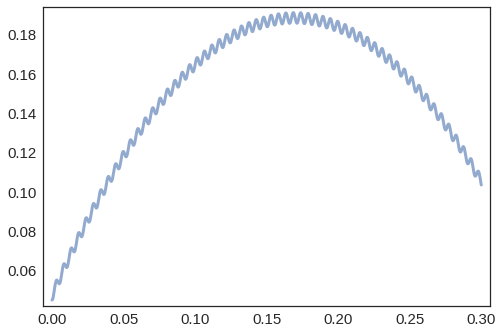

In [405]:
plot(system.results.x1)

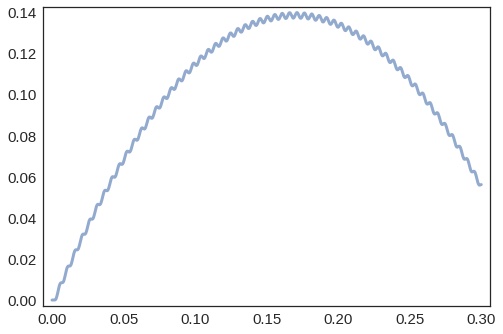

In [406]:
plot(system.results.x2)

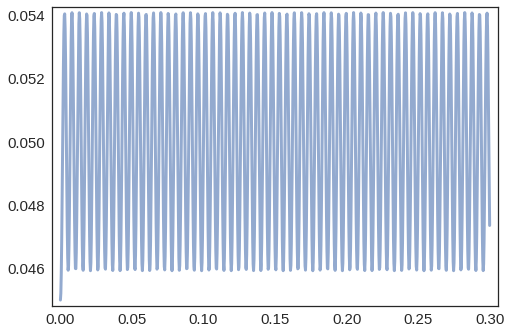

In [407]:
plot(system.results.x1 - system.results.x2)

In [14]:
plot(ys, color='green', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (m)')

Plotting `r`

In [15]:
plot(rs, color='red', label='r')

decorate(xlabel='Time (s)',
         ylabel='Radius (mm)')

We can also see the relationship between `y` and `r`, which I derive analytically in the book.

In [16]:
plot(rs, ys, color='purple')

decorate(xlabel='Radius (mm)',
         ylabel='Length (m)',
         legend=False)

And here's the figure from the book.

In [17]:
subplot(3, 1, 1)
plot(thetas, label='theta')
decorate(ylabel='Angle (rad)')

subplot(3, 1, 2)
plot(ys, color='green', label='y')
decorate(ylabel='Length (m)')

subplot(3, 1, 3)
plot(rs, color='red', label='r')

decorate(xlabel='Time(s)',
         ylabel='Radius (mm)')

savefig('chap11-fig01.pdf')

We can use interpolation to find the time when `y` is 47 meters.

In [18]:
T = interp_inverse(ys, kind='cubic')
t_end = T(47)
t_end

At that point `r` is 55 mm, which is `Rmax`, as expected.

In [19]:
R = interpolate(rs, kind='cubic')
R(t_end)

The total amount of rotation is 1253 rad.

In [20]:
THETA = interpolate(thetas, kind='cubic')
THETA(t_end)

### Unrolling

For unrolling the paper, we need more units:

In [21]:
kg = UNITS.kilogram
N = UNITS.newton

And a few more parameters in the `Condition` object.

In [22]:
condition = Condition(Rmin = 0.02 * m,
                      Rmax = 0.055 * m,
                      Mcore = 15e-3 * kg,
                      Mroll = 215e-3 * kg,
                      L = 47 * m,
                      tension = 2e-4 * N,
                      duration = 180 * s)

`make_system` computes `rho_h`, which we'll need to compute moment of inertia, and `k`, which we'll use to compute `r`.

In [23]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition with Rmin, Rmax, Mcore, Mroll,
                              L, tension, and duration
    
    returns: System with init, k, rho_h, Rmin, Rmax,
                         Mcore, Mroll, ts
    """
    unpack(condition)
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = L)
    
    area = pi * (Rmax**2 - Rmin**2)
    rho_h = Mroll / area
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    ts = linspace(0, duration, 101)
    
    return System(init=init, k=k, rho_h=rho_h,
                  Rmin=Rmin, Rmax=Rmax,
                  Mcore=Mcore, Mroll=Mroll, 
                  ts=ts)

Testing `make_system`

In [24]:
system = make_system(condition)
system

In [25]:
system.init

Here's how we compute `I` as a function of `r`:

In [26]:
def moment_of_inertia(r, system):
    """Moment of inertia for a roll of toilet paper.
    
    r: current radius of roll in meters
    system: System object with Mcore, rho, Rmin, Rmax
    
    returns: moment of inertia in kg m**2
    """
    unpack(system)
    Icore = Mcore * Rmin**2   
    Iroll = pi * rho_h / 2 * (r**4 - Rmin**4)
    return Icore + Iroll

When `r` is `Rmin`, `I` is small.

In [27]:
moment_of_inertia(system.Rmin, system)

As `r` increases, so does `I`.

In [28]:
moment_of_inertia(system.Rmax, system)

Here's the slope function.

In [29]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, omega, y
    t: time
    system: System object with Rmin, k, Mcore, rho_h, tension
    
    returns: sequence of derivatives
    """
    theta, omega, y = state
    unpack(system)
    
    r = sqrt(2*k*y + Rmin**2)
    I = moment_of_inertia(r, system)
    tau = r * tension
    alpha = tau / I
    dydt = -r * omega
    
    return omega, alpha, dydt      

Testing `slope_func`

In [30]:
slope_func(system.init, 0*s, system)

Now we can run the simulation.

In [31]:
run_odeint(system, slope_func)

And look at the results.

In [32]:
system.results.tail()

Extrating the time series

In [33]:
thetas = system.results.theta
omegas = system.results.omega
ys = system.results.y

Plotting `theta`

In [34]:
plot(thetas, label='theta')

decorate(xlabel='Time (s)',
         ylabel='Angle (rad)')

Plotting `omega`

In [35]:
plot(omegas, color='orange', label='omega')

decorate(xlabel='Time (s)',
         ylabel='Angular velocity (rad/s)')

Plotting `y`

In [36]:
plot(ys, color='green', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (m)')

Here's the figure from the book.

In [37]:
subplot(3, 1, 1)
plot(thetas, label='theta')
decorate(ylabel='Angle (rad)')

subplot(3, 1, 2)
plot(omegas, color='orange', label='omega')
decorate(ylabel='Angular velocity (rad/s)')

subplot(3, 1, 3)
plot(ys, color='green', label='y')

decorate(xlabel='Time(s)',
         ylabel='Length (m)')

savefig('chap11-fig02.pdf')

### Yo-yo

**Exercise:**  Simulate the descent of a yo-yo.  How long does it take to reach the end of the string.

I provide a `Condition` object with the system parameters:

* `Rmin` is the radius of the axle.  `Rmax` is the radius of the axle plus rolled string.

* `Rout` is the radius of the yo-yo body.  `mass` is the total mass of the yo-yo, ignoring the string.  

* `L` is the length of the string.

* `g` is the acceleration of gravity.

In [38]:
condition = Condition(Rmin = 8e-3 * m,
                      Rmax = 16e-3 * m,
                      Rout = 35e-3 * m,
                      mass = 50e-3 * kg,
                      L = 1 * m,
                      g = 9.8 * m / s**2,
                      duration = 1 * s)

Here's a `make_system` function that computes `I` and `k` based on the system parameters.

I estimated `I` by modeling the yo-yo as a solid cylinder with uniform density ([see here](https://en.wikipedia.org/wiki/List_of_moments_of_inertia)).  In reality, the distribution of weight in a yo-yo is often designed to achieve desired effects.  But we'll keep it simple.

In [39]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition with Rmin, Rmax, Rout, 
                              mass, L, g, duration
    
    returns: System with init, k, Rmin, Rmax, mass,
                         I, g, ts
    """
    unpack(condition)
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = L,
                 v = 0 * m / s)
    
    I = mass * Rout**2 / 2
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    ts = linspace(0, duration, 101)
    
    return System(init=init, k=k,
                  Rmin=Rmin, Rmax=Rmax,
                  mass=mass, I=I, g=g,
                  ts=ts)

Testing `make_system`

In [40]:
system = make_system(condition)
system

In [41]:
system.init

Write a slope function for this system, using these results from the book:

$ r = \sqrt{2 k y + R_{min}^2} $ 

$ T      = m g I / I^*  $

$ a      = -m g r^2 / I^* $

$ \alpha  = m g r / I^*  $

where $I^*$ is the augmented moment of inertia, $I + m r^2$.

Hint: If `y` is less than 0, it means you have reached the end of the string, so the equation for `r` is no longer valid.  In this case, the simplest thing to do it return the sequence of derivatives `0, 0, 0, 0`

In [42]:
# Solution goes here

Test your slope function with the initial conditions.

In [43]:
slope_func(system.init, 0*s, system)

Then run the simulation.

In [44]:
run_odeint(system, slope_func)

Check the final conditions.  If things have gone according to plan, the final value of `y` should be close to 0.

In [45]:
system.results.tail()

Plot the results.

In [46]:
thetas = system.results.theta
ys = system.results.y

`theta` should increase and accelerate.

In [47]:
plot(thetas, label='theta')

decorate(xlabel='Time (s)',
         ylabel='Angle (rad)')

`y` should decrease and accelerate down.

In [48]:
plot(ys, color='green', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (m)')